## PHY 411: Final Project
### Jeremy Kazimer
### 5018-1732

---

#### _Import Statements_

To begin this portion of the project, we import the Python file I created which contains the network class and its methods:

In [1]:
from generate_network import *

Consider that an explanation of the code is partially within the .py itself, but also in the documentation on GitHub.  We can also import `numpy`, `matplotlib`, and `time` such that we can use their code here:

In [22]:
import time
from numpy import arange, array, exp, log, mean, polyfit, sqrt, std, zeros
from matplotlib import pyplot as plt

Now, we can begin to generate networks.

#### _Generating Networks_

For an Erdős–Rényi network, the only parameters needed to create it are the numbers of nodes $N$ and the edge probability $p$.  These generate a random number of edges each time, but in general it gravitates around the value

\begin{equation}
\bar{M} = \dfrac{N\left[N - 1\right]}{2} \cdot p
\end{equation}

The derivation of this can be found in theory.  Furthermore, the graph is random in the sense that their placement with respect to the nodes is also random.  With that, since both of those conditions are random but constrained according to the initial conditions, we can take that into consideration later with respect to the Monte Carlo simulation.  Regardless, we can generate a network with the following conditions:

In [3]:
N = 100
p = 0.25

In [4]:
G = Erdos_Renyi_GNP(N, p)

We can spy the graph, to get an idea of what this actually looks like:

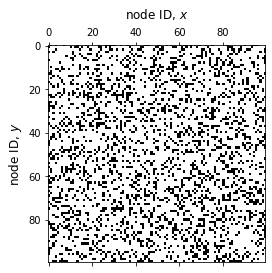

In [5]:
fig, ax = G.plot_graph()

And a NetworkX graph, which is a bit more obvious to me:

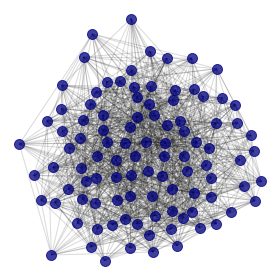

In [6]:
fig, ax = G.plot_networkx()

With that, we can validate properties of our network:

#### _Graph Validation_

There are a few ways to verify that our creation is vaguely correct.  Remember that it is random and therefore there are not always exact values to compare.  The first we can do is assert that the shape of the adjacency is $N \times N$:

In [7]:
assert(G.A.shape == (N, N))

Moreover, the number of edges should vaguely be between

\begin{equation}
\dfrac{N\left[N - 1\right]}{2} \cdot p
\end{equation}

Although we don't have a precise form for a standard deviation right now, for now we can treat it as 

\begin{equation}
\sigma_{\bar{M}} = 10\% \cdot \bar{M}
\end{equation}

In [8]:
bar_m = lambda N, p: N*(N - 1)/2 * p
std_m = lambda N, p: 0.10 * bar_m(N, p)

In [9]:
assert((G.M < bar_m(N, p) + std_m(N, p)) and (G.M > bar_m(N, p) - std_m(N, p)))

Just to assert that this isn't the case for just this particular graph, we can iterate over and do the same:

In [11]:
for _ in range(100):
    G1 = Erdos_Renyi_GNP(N, p)
    assert((G1.M < bar_m(N, p) + std_m(N, p)) and (G1.M > bar_m(N, p) - std_m(N, p)))

Besides that, we can also check that the length of the current edges (values of 1) and the length of the potential edges (values of 0) sum to be the total possible number of edges

\begin{equation}
\dfrac{N\left[N - 1\right]}{2}
\end{equation}

In [12]:
assert(G.edges.shape[0] == G.M)
assert(G.edges.shape[0] + G.potential_edges.shape[0] == G.N*(G.N - 1)/2)

Lastly, we can test that rewiring, that is the addition and removal of edges, keeps the same number of edges throughout.  This is because we're dealing here with an unweighted, bidirectional graph such that each addition adds one edge and removal removes an edge.  So, the net change should be zero, always:

In [13]:
M = G.M
for _ in range(100):
    G.rewire_graph()
    assert(G.M == M)

With that, we can now time this code to ensure that it's viable on a device like the Pi Zero W:

#### _Runtime Analysis_

Of course, the first thing that should be done is checking how long the creation of a network takes, $t$, for some odd amount of trials.  Here, we'll re-use the same initial conditions:

In [15]:
trials = 100

ts = zeros((trials))
Ms = zeros((trials))

for trial in range(trials):
    
    t0 = time.time()
    G1 = Erdos_Renyi_GNP(N, p)
    t1 = time.time()
    
    ts[trial] = t1 - t0
    Ms[trial] = G1.M

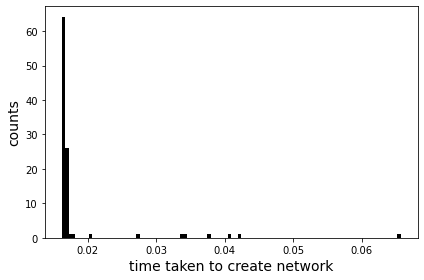

In [16]:
fig, ax = plt.subplots(1, 1)

ax.hist(ts, 100, color = 'black');

ax.set_ylabel('counts', fontsize = 14)
ax.set_xlabel('time taken to create network', fontsize = 14)

fig.tight_layout()

We see in general that the times are fairly close to zero, but there exists a noticeable chunk separated from the rest...could this be dependent on the number of edges? Consider that the only thing that changes is $M$, since it's purely probabilistic.  So, we can look at that:

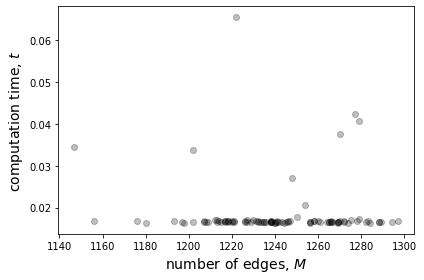

In [17]:
fig, ax = plt.subplots(1, 1)

ax.scatter(Ms, ts, alpha = 0.25, c = 'black')

ax.set_ylabel('computation time, $t$', fontsize = 14)
ax.set_xlabel('number of edges, $M$', fontsize = 14)

fig.tight_layout();

We see here that this is not the case.  This is good to establish in order to understand that sometimes things just take longer for internal reasons.  OK, so we've established for the case where $N$ and $p$ don't vary, but what about the cases where they do? For now, we'll only vary $N$:

In [19]:
trials = 10

Ns = arange(2, 250, 2)
ts = zeros((Ns.shape[0], trials))

for trial in range(trials):
    for N in Ns:
        t0 = time.time()
        G1 = Erdos_Renyi_GNP(N, p)
        t1 = time.time()

        ts[N//2 - 1, trial] = t1 - t0

Here, we take the average of the trials.  Otherwise, there would be too many data points to take into consideration.  We attach errorbars such that we can see how much they deviate by:

In [23]:
bar_ts = mean(ts, axis = 1)
std_ts = std(ts, axis = 1)
err_ts = std_ts/sqrt(trials)

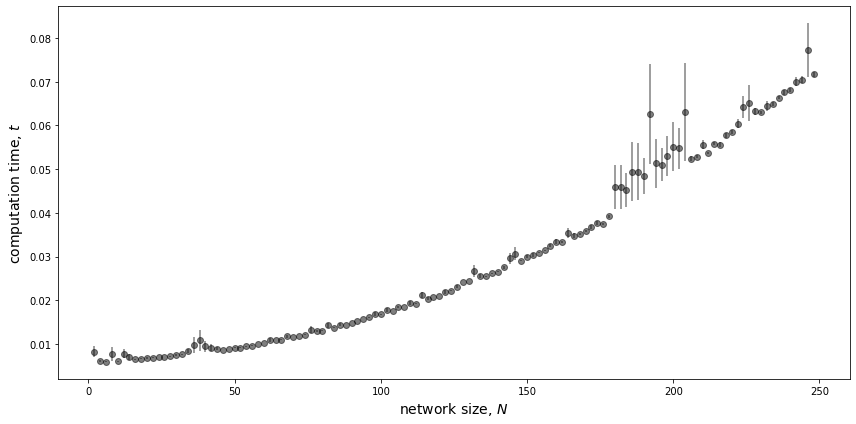

In [24]:
fig, ax = plt.subplots(1, 1, figsize = (12, 6))

ax.errorbar(Ns, bar_ts, yerr = err_ts, fmt = 'o', c = 'k', alpha = 0.5)

ax.set_ylabel('computation time, $t$', fontsize = 14)
ax.set_xlabel('network size, $N$', fontsize = 14)

fig.tight_layout()

We see that the distribution tends to spread out as $N$ increases.  This is probably suggesting that $\sigma_{\bar{M}}$ is a function of $N$, which is assumed to be true.  Regardless, we see that it scales strongly with $N$, but how strong? We can implement a log fit such that

\begin{equation}
\log(t) = A \cdot \log(N) + B
\end{equation}

where $A$ is the log slope and $B$ is the log intercept.  Then, our leading runtime coefficient $c$ and base case $d$ would be
\begin{equation}
c = e^{A}
\end{equation}

and

\begin{equation}
d = e^{B}
\end{equation}

Consider this comes from the form $\mathcal{O}(N^c)$ where we predict that the graph will scale with $N$, since that parameter is the one that we changed. Taking the log of both sides brings the coefficient to a product, due to log rules.  Now, applying this:

In [25]:
c, d = exp(polyfit(log(Ns), log(bar_ts), 1))

In [26]:
print(c, d)

2.0681562857832274 0.000822926683333973


Of course, $d$ should really be zero since nothing would calculate for a network of size $0$.  However, $c$ in general agrees with our understanding.  Since the size of the array scales via $N \times N$, we see this to be $N^2$.  This means at the very least the runtime coefficient should be no smaller than this.  However, in our functions there are other processes at play such that it's more realistic this $c$ value comes from `numpy` not being able to bring vector operations down to scale precisely with the size of the array.  

Regardless, it is good to see our program is close to its maximal efficiency.  Note that this is **not** the fit of the line, but rather fitting the data to find the coefficient of the leading $N$ term.  We could now apply `np.polyfit` and round up or down the coefficient and apply a proper fit, but that isn't necessary at this point.  

Lastly, we can record the time it takes to rewire a graph $t$ amount of times.  This will give us an idea of how long this process takes.

In [27]:
rewires = 1000

ts = zeros((rewires))

for rewire in range(rewires):
    
    t0 = time.time()
    G.rewire_graph()
    t1 = time.time()
    
    ts[rewire] = t1 - t0

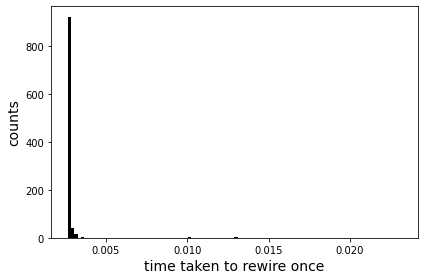

In [28]:
fig, ax = plt.subplots(1, 1)

ax.hist(ts, 100, color = 'black');

ax.set_ylabel('counts', fontsize = 14)
ax.set_xlabel('time taken to rewire once', fontsize = 14)

fig.tight_layout()

Really, not that long at all! So, it is viable on the Pi Zero W, after all.

## To be continued...